In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from catboost import CatBoostClassifier
import lightgbm as lgb

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("/kaggle/input/train-dataset/Train_Data.csv")
df_test = pd.read_csv("/kaggle/input/test-dataset/Test_Data.csv")
submission = pd.read_csv("/kaggle/input/submission/Sample_Submission.csv")

In [3]:
submission.head()

,attack
0,0
1,0
2,0
3,1
4,1


In [4]:
df_train.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
0,0,tcp,netbios_dgm,REJ,0,0,0,0,0,0,...,0.06,0.06,0.00,0.00,0.00,0.0,1.00,1.0,21,1
1,0,tcp,smtp,SF,1239,400,0,0,0,0,...,0.45,0.04,0.00,0.00,0.11,0.0,0.02,0.0,18,0
2,0,tcp,http,SF,222,945,0,0,0,0,...,1.00,0.00,0.02,0.03,0.00,0.0,0.00,0.0,21,0
3,0,tcp,http,SF,235,1380,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,21,0
4,0,tcp,uucp_path,REJ,0,0,0,0,0,0,...,0.01,0.08,0.00,0.00,0.00,0.0,1.00,1.0,19,1


In [5]:
df_train.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'land', 'wrongfragment', 'urgent', 'hot', 'numfailedlogins', 'loggedin',
       'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'lastflag', 'attack'],
      dtype='object')

In [6]:
df_train.nunique()

duration                  1594
protocoltype                 3
service                     65
flag                        10
srcbytes                  3022
dstbytes                  8367
land                         2
wrongfragment                1
urgent                       3
hot                         25
numfailedlogins              5
loggedin                     2
numcompromised              73
rootshell                    2
suattempted                  3
numroot                     64
numfilecreations            33
numshells                    3
numaccessfiles              10
numoutboundcmds              1
ishostlogin                  2
isguestlogin                 2
count                      468
srvcount                   467
serrorrate                  62
srvserrorrate               81
rerrorrate                  55
srvrerrorrate               57
samesrvrate                 99
diffsrvrate                 84
srvdiffhostrate             59
dsthostcount               256
dsthosts

In [7]:
df_train.drop(['wrongfragment', 'numoutboundcmds'], inplace=True, axis=1)

In [8]:
df_test.drop(['wrongfragment', 'numoutboundcmds'], inplace=True, axis=1)

In [9]:
pd.set_option('display.max_columns', None)
df_train.describe()

,duration,srcbytes,dstbytes,land,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
count,86845.000000,8.684500e+04,8.684500e+04,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000
mean,104.166872,8.455707e+03,2.732095e+03,0.000046,0.000035,0.144971,0.000771,0.441142,0.320583,0.001347,0.001267,0.356382,0.014370,0.000357,0.004548,0.000012,0.008060,79.584939,21.308838,0.324545,0.323482,0.091022,0.091223,0.639490,0.045231,0.078523,186.012067,123.338269,0.526457,0.050186,0.075810,0.016246,0.324666,0.318934,0.092391,0.091045,20.060522,0.379964
std,1038.273538,3.582141e+05,5.543041e+04,0.006787,0.007588,1.837958,0.037009,0.496527,27.993474,0.036680,0.048450,28.415210,0.528799,0.020072,0.104986,0.003393,0.089417,98.068071,48.212191,0.464948,0.464469,0.286221,0.285844,0.444652,0.122168,0.222239,95.946960,112.704010,0.447353,0.103323,0.208388,0.055271,0.464291,0.463506,0.282768,0.281452,1.421425,0.485380
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,93.000000,12.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
50%,0.000000,4.600000e+01,4.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,77.000000,0.550000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000
75%,0.000000,2.720000e+02,7.680000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,17.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.020000,0.010000,1.000000,1.000000,0.000000,0.000000,21.000000,1.000000
max,40504.000000,8.958152e+07,7.028652e+06,1.000000,2.000000,77.000000,4.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000


In [10]:
df_train.dtypes

duration                    int64
protocoltype               object
service                    object
flag                       object
srcbytes                    int64
dstbytes                    int64
land                        int64
urgent                      int64
hot                         int64
numfailedlogins             int64
loggedin                    int64
numcompromised              int64
rootshell                   int64
suattempted                 int64
numroot                     int64
numfilecreations            int64
numshells                   int64
numaccessfiles              int64
ishostlogin                 int64
isguestlogin                int64
count                       int64
srvcount                    int64
serrorrate                float64
srvserrorrate             float64
rerrorrate                float64
srvrerrorrate             float64
samesrvrate               float64
diffsrvrate               float64
srvdiffhostrate           float64
dsthostcount  

In [11]:
columns = ['protocoltype', 'service', 'flag']
label_encoder = LabelEncoder()
df_train['service'] = label_encoder.fit_transform(df_train['service'])
df_train['flag'] = label_encoder.fit_transform(df_train['flag'])
df_train['protocoltype'] = label_encoder.fit_transform(df_train['protocoltype'])
df_test['service'] = label_encoder.fit_transform(df_test['service'])
df_test['flag'] = label_encoder.fit_transform(df_test['flag'])
df_test['protocoltype'] = label_encoder.fit_transform(df_test['protocoltype'])

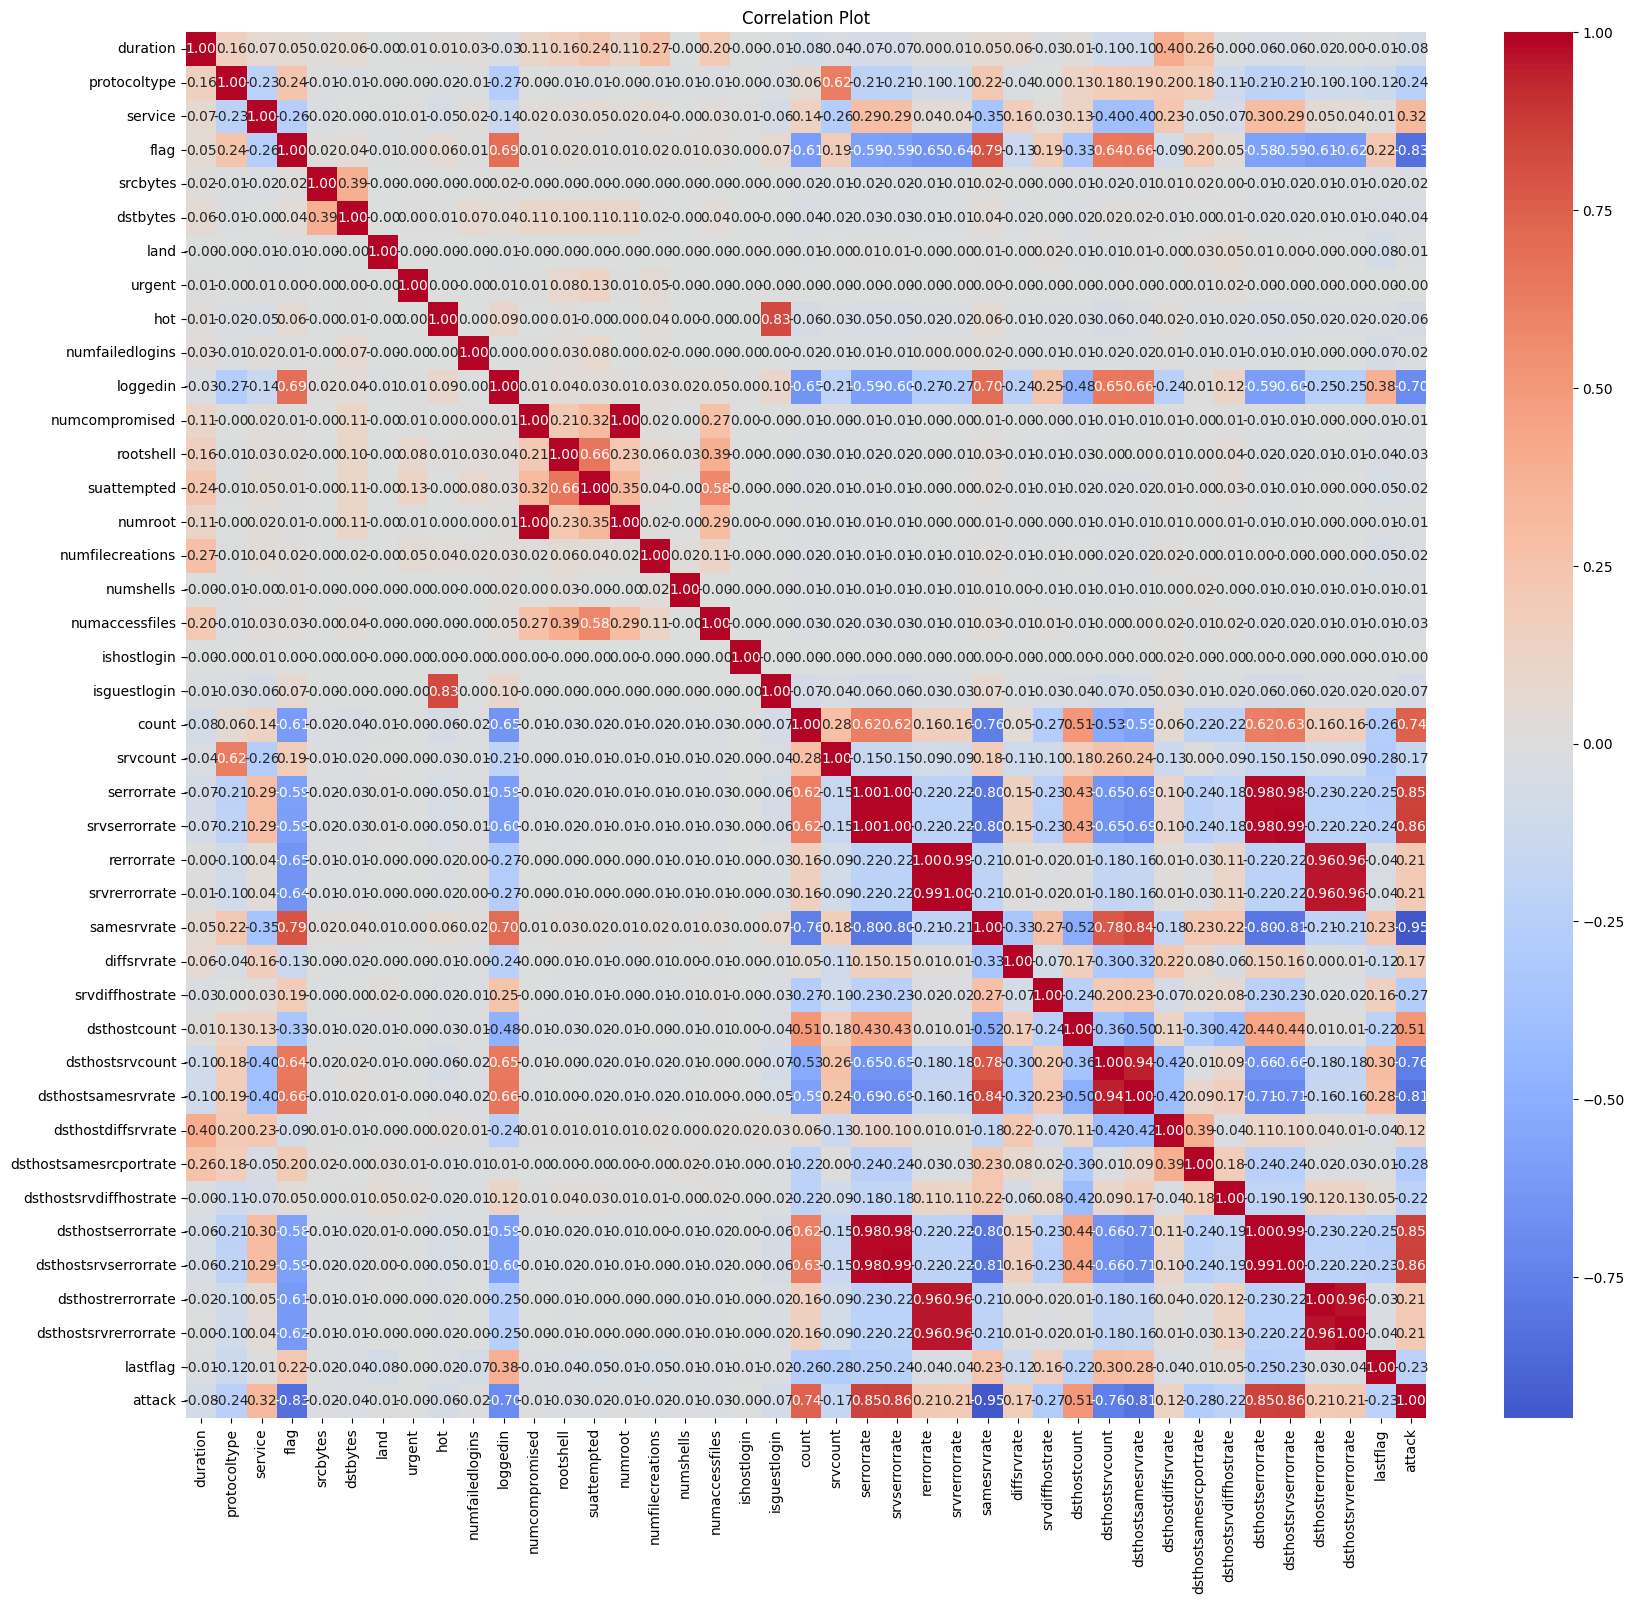

In [12]:
# Calculate correlation matrix
corr_matrix = df_train.corr()

# Plotting correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Plot')
plt.show()

In [13]:
X = df_train.drop('attack', axis=1)
y = df_train['attack']

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    #'Support Vector Classifier': SVC(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'XGBoost Classifier': XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_seed=42, silent=True)
}

In [16]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.2f}')
    print(f'  F1 Score: {f1:.2f}\n')
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)  
    print(f"{name} confusion matrix:\n")
    print(conf_matrix)
    print("\n")

Logistic Regression:
  Accuracy: 1.00
  F1 Score: 1.00

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10762
           1       1.00      1.00      1.00      6607

    accuracy                           1.00     17369
   macro avg       1.00      1.00      1.00     17369
weighted avg       1.00      1.00      1.00     17369

Logistic Regression confusion matrix:

[[10757     5]
 [    5  6602]]


Decision Tree:
  Accuracy: 1.00
  F1 Score: 1.00

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10762
           1       1.00      1.00      1.00      6607

    accuracy                           1.00     17369
   macro avg       1.00      1.00      1.00     17369
weighted avg       1.00      1.00      1.00     17369

Decision Tree confusion matrix:

[[10758     4]
 [    2  6605]]


Random Forest:
  Acc

In [17]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(df_test)

In [18]:
submission = pd.DataFrame({
    "attack": y_pred
})

In [19]:
submission.to_csv("submission.csv")

In [20]:
submission

,attack
0,1
1,0
2,1
3,1
4,1
...,...
21707,0
21708,0
21709,1
21710,0
